In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCMT, GroverOperator
from qiskit.quantum_info import Statevector
from math import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.circuit import Parameter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_image_path
import seaborn as sns
from qutip import Bloch, Qobj
from itertools import combinations

In [2]:
def get_diffuser(total_qubits):
    mct = MCMT('x', total_qubits-1, 1)
    qc = QuantumCircuit(total_qubits)
    qc.h(range(total_qubits))
    qc.x(range(total_qubits))

    qc.h(-1)
    qc.compose(mct, range(total_qubits), inplace=True)
    qc.h(-1)
    
    qc.x(range(total_qubits))
    qc.h(range(total_qubits))
    return qc

In [3]:
def classical_grover(oracle):
    total_qubits = oracle.num_qubits
    qc = QuantumCircuit(total_qubits)
    grover = GroverOperator(oracle).decompose()
    qc.h(range(total_qubits))
    qc.compose(grover, range(total_qubits), inplace=True)
    return qc

In [4]:
def phase_oracle(states):
    total_qubits = len(states[0])
    mct = MCMT('z', total_qubits-1, 1)
    
    qc = QuantumCircuit(total_qubits, name="oracle")
    for state in states:
        zeros = [i for i, bit in enumerate(state[::-1]) if bit == '0']
        if(zeros): qc.x(zeros)
        qc.compose(mct,range(total_qubits),inplace=True)
        if(zeros): qc.x(zeros)
    return qc

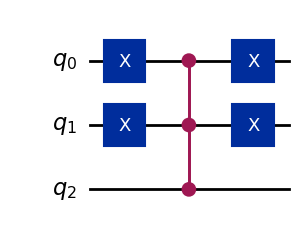

In [5]:
oracle = phase_oracle(['100'])
oracle.draw('mpl')

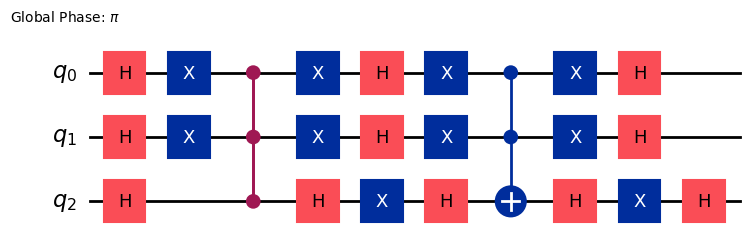

In [6]:
classical_grover(oracle).draw('mpl')

In [5]:
def get_counts(qc, sim=AerSimulator(), shots=1000):
    qc_c = qc.copy()
    qc_c.measure_all()
    transpiled = transpile(qc_c, sim)
    return sim.run(transpiled, shots=shots).result().get_counts()

In [6]:
def new_grover(oracle):
    theta = Parameter('theta')
    total_qubits = oracle.num_qubits
    
    qc = QuantumCircuit(total_qubits)
    qc.ry(theta, range(total_qubits))
    qc.barrier()
    qc.append(oracle, range(total_qubits))
    qc.barrier()
    qc.compose(get_diffuser(total_qubits), range(total_qubits), inplace=True)
    
    return qc, theta

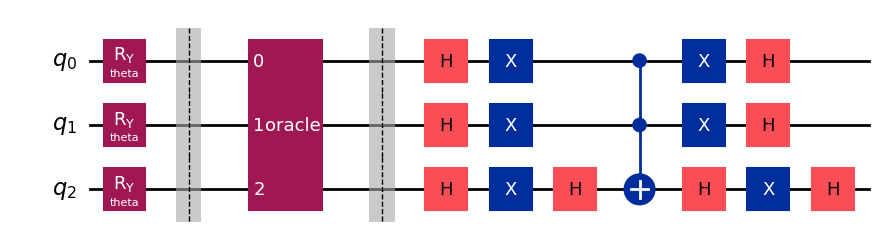

In [9]:
n_grover,theta = new_grover(oracle) 
n_grover.draw('mpl')

In [7]:
def find_best_angle(theta, qc, values_space, target_bit_string, debug=False):
    best_angle = 0
    best_total = 0
    
    for angle in values_space:
        bc = qc.assign_parameters({theta:angle})
        counts = get_counts(bc)

        value = 0
        if(counts.get(target_bit_string)):
            value = counts[target_bit_string]

        if(value > best_total):
            best_total = value
            best_angle = angle
        
        if(debug):
            print(angle, value)

    return best_angle, best_total

In [11]:
best_angle, best_total = find_best_angle(theta, n_grover, np.linspace(0, pi, num=1000), '001', debug=True)

0.0 61
0.0031447373909807737 46
0.006289474781961547 54
0.009434212172942321 59
0.012578949563923095 59
0.01572368695490387 60
0.018868424345884642 55
0.022013161736865416 56
0.02515789912784619 47
0.028302636518826963 55
0.03144737390980774 52
0.034592111300788514 54
0.037736848691769284 46
0.040881586082750054 54
0.04402632347373083 55
0.04717106086471161 59
0.05031579825569238 71
0.05346053564667315 44
0.056605273037653926 42
0.0597500104286347 49
0.06289474781961547 46
0.06603948521059624 55
0.06918422260157703 57
0.0723289599925578 59
0.07547369738353857 53
0.07861843477451934 57
0.08176317216550011 48
0.08490790955648089 50
0.08805264694746166 49
0.09119738433844243 54
0.09434212172942322 52
0.09748685912040399 50
0.10063159651138476 39
0.10377633390236553 34
0.1069210712933463 47
0.11006580868432708 49
0.11321054607530785 40
0.11635528346628862 54
0.1195000208572694 52
0.12264475824825018 42
0.12578949563923095 35
0.12893423303021173 40
0.1320789704211925 43
0.13522370781217327 

In [12]:
best_angle, best_total

(2.506355700611677, 159)

In [8]:
BIT_STRINGS_3 = ['000', '001', '010', '011', '100', '101', '110', '111']

In [9]:
def compare_old_new_1_bit_string(bit_strings, values_space, debug=False):
    old = {}
    new = {}
    angles = {}
    
    for bit_string in bit_strings:
        oracle = phase_oracle([bit_string])

        old_ = classical_grover(oracle.copy())
        if(debug):
            display(old_.draw('mpl'))
        
        old_counts = get_counts(old_)
        old_total = 0
        if(old_counts.get(bit_string)):
            old[bit_string] = old_counts[bit_string]

        new_, theta = new_grover(oracle.copy())
        angle, max_ = find_best_angle(theta, new_, values_space, bit_string)
        new[bit_string] = max_
        angles[bit_string] = angle

    data = {"old":old, "new":new, "angles":angles}
    return pd.DataFrame(data, columns=("old", "new", "angles"), index=bit_strings)
        
        
        

In [15]:
results_1 = compare_old_new_1_bit_string(BIT_STRINGS_3, np.linspace(0, pi, num=500))
results_1

,old,new,angles
000,787,949,1.013620
001,784,808,1.385071
010,780,819,1.479508
011,791,818,1.680972
100,768,811,1.397662
101,766,812,1.712451
110,765,819,1.699860
111,789,942,2.058719


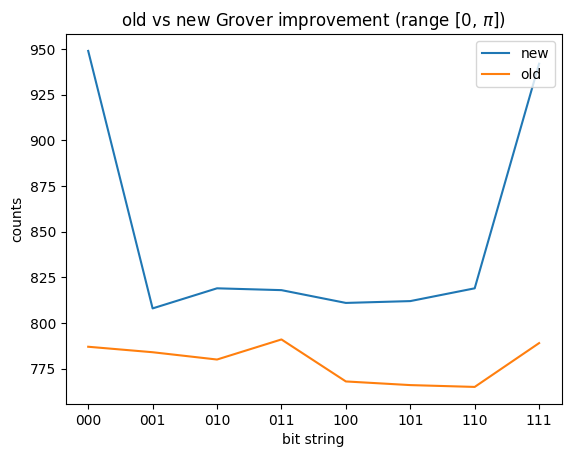

In [16]:
plt.plot(results_1.index.tolist(), results_1['new'], label="new")
plt.plot(results_1.index.tolist(), results_1['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("superposition-improvement-grover-algorithm-range-0-to-pi.png"))
plt.show()

In [17]:
results_2 = compare_old_new_1_bit_string(BIT_STRINGS_3, np.linspace(0, 2*pi, num=500))
results_2

,old,new,angles
000,774,939,1.082874
001,783,809,1.435437
010,779,817,1.473212
011,778,810,1.699860
100,759,826,1.422846
101,796,820,1.624310
110,787,806,1.674677
111,778,937,2.077606


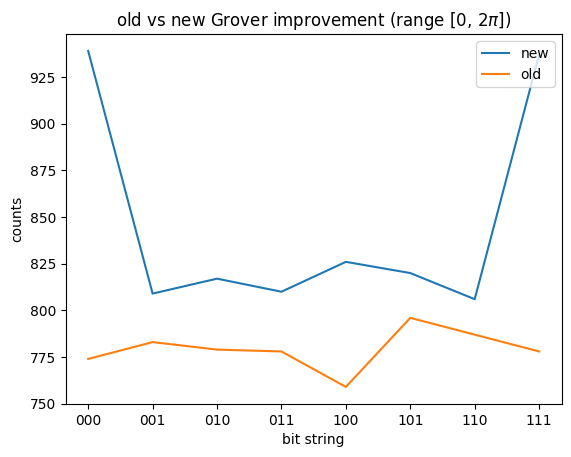

In [18]:
plt.plot(results_2.index.tolist(), results_2['new'], label="new")
plt.plot(results_2.index.tolist(), results_2['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.legend(loc="upper right")

plt.savefig(get_image_path("superposition-improvement-grover-algorithm-range-0-to-2pi.png"))
plt.show()

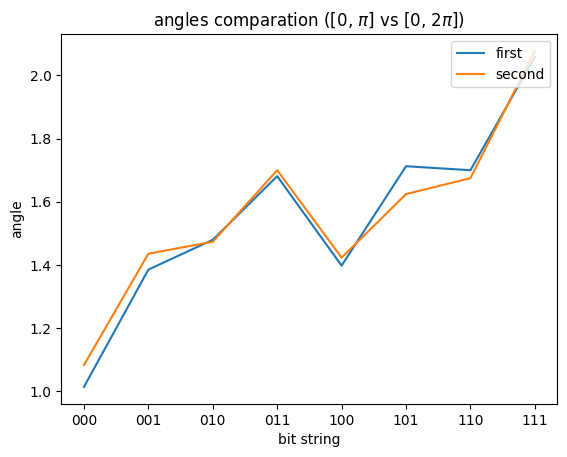

In [19]:
plt.plot(BIT_STRINGS_3, results_1['angles'], label="first")
plt.plot(BIT_STRINGS_3, results_2['angles'], label="second")
plt.title('angles comparation ([0, $\pi$] vs [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("angle")
plt.legend(loc="upper right")
plt.savefig(get_image_path("improvement-grover-algorithm-angles-comparation-0-pi-and-2pi.png"))
plt.show()

In [10]:
results_3 = compare_old_new_1_bit_string([bin(i)[2:].zfill(4) for i in range(2**4)], np.linspace(0, 2*pi, num=500))
results_3

,old,new,angles
0000,490,883,0.579211
0001,482,539,1.385071
0010,457,530,1.359888
0011,485,489,1.674677
0100,459,530,1.208789
0101,441,503,1.473212
0110,481,493,1.611719
0111,486,544,1.863550
1000,462,529,1.296930
1001,468,500,1.448029


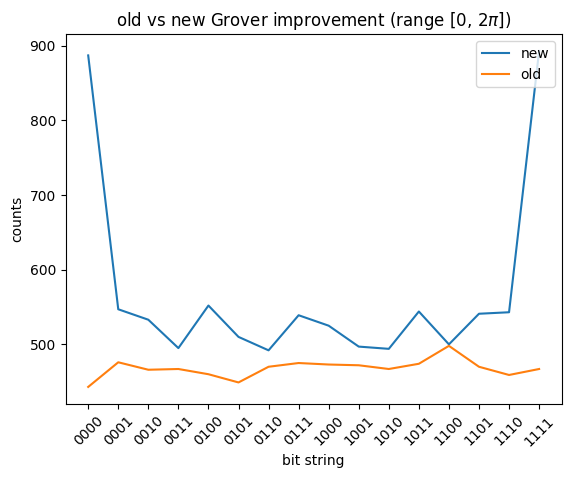

In [34]:
plt.plot(results_3.index.tolist(), results_3['new'], label="new")
plt.plot(results_3.index.tolist(), results_3['old'], label="old")
plt.title('old vs new Grover improvement (range [0, $2\pi$])')
plt.xlabel("bit string")
plt.ylabel("counts")
plt.xticks(rotation = 45)
plt.legend(loc="upper right")
plt.savefig(get_image_path("improvement-grover-algorithm-4bits-0-to-2pi.png"))
plt.show()

In [25]:
pi/2

1.5707963267948966

In [30]:
mid_values = results_3["angles"].drop(["0000", "1111"])
mid_values

0001    1.183606
0010    1.208789
0011    1.561353
0100    1.372479
0101    1.636902
0110    1.573944
0111    1.800592
1000    1.422846
1001    1.448029
1010    1.712451
1011    1.964282
1100    1.523578
1101    1.775409
1110    1.813184
Name: angles, dtype: float64

In [56]:
mid_values.describe()

count    14.000000
mean      1.571246
std       0.230764
min       1.183606
25%       1.429141
50%       1.567648
75%       1.759670
max       1.964282
Name: angles, dtype: float64

In [73]:
mid_values.mean(), pi/2

(1.5712460251421039, 1.5707963267948966)

---

In [15]:
bloch_data = results_3
bloch_data['alfa'] = np.cos(bloch_data["angles"]/2)
bloch_data['beta'] = np.sin(bloch_data["angles"]/2)
bloch_data

,old,new,angles,alfa,beta
0000,490,883,0.579211,0.958357,0.285574
0001,482,539,1.385071,0.769630,0.638491
0010,457,530,1.359888,0.777608,0.628749
0011,485,489,1.674677,0.669442,0.742864
0100,459,530,1.208789,0.822846,0.568264
0101,441,503,1.473212,0.740753,0.671778
0110,481,493,1.611719,0.692491,0.721426
0111,486,544,1.863550,0.596410,0.802680
1000,462,529,1.296930,0.797012,0.603964
1001,468,500,1.448029,0.749153,0.662397


In [10]:
def show_bloch(states):
    bloch = Bloch()
    bloch.make_sphere()
    bloch.add_states(states)
    display(bloch.show())

In [65]:
for i in bloch_data.index.tolist():
    print(i, i.count('0'))

0000 4
0001 3
0010 3
0011 2
0100 3
0101 2
0110 2
0111 1
1000 3
1001 2
1010 2
1011 1
1100 2
1101 1
1110 1
1111 0


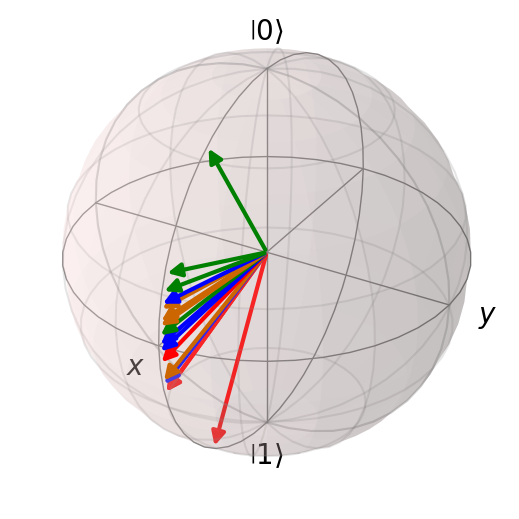

None

In [70]:
states = []
for i in range(len(bloch_data)):
    row = bloch_data.iloc[i]
    alfa,beta = row['alfa'], row['beta']
    states.append(Qobj([[alfa], [beta]]))
show_bloch(states)

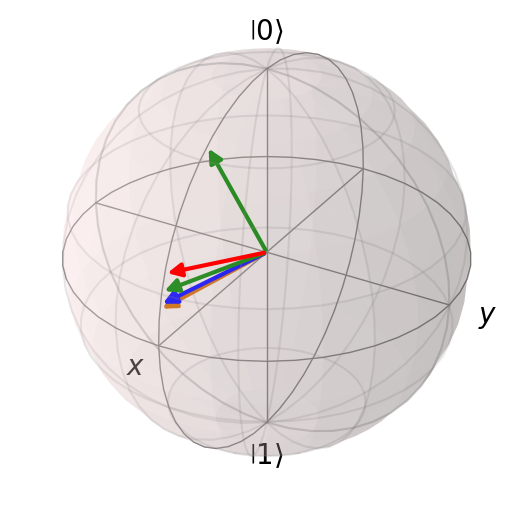

None

In [71]:
states = []
for i in range(len(bloch_data)):
    row = bloch_data.iloc[i]
    
    if(row.name.count('0') >= 3):
        alfa,beta = row['alfa'], row['beta']
        states.append(Qobj([[alfa], [beta]]))
show_bloch(states)

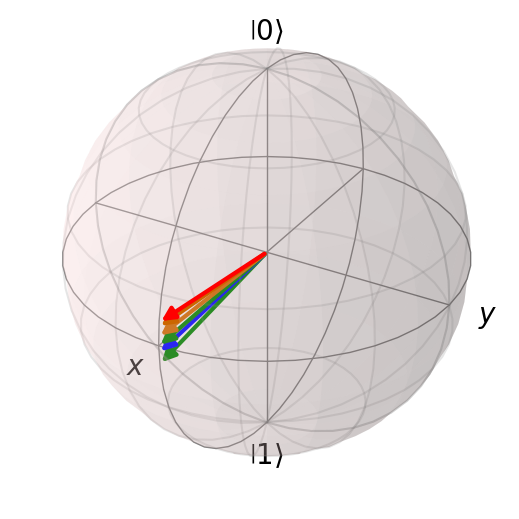

None

In [72]:
states = []
for i in range(len(bloch_data)):
    row = bloch_data.iloc[i]
    
    if(row.name.count('0') == 2):
        alfa,beta = row['alfa'], row['beta']
        states.append(Qobj([[alfa], [beta]]))
show_bloch(states)

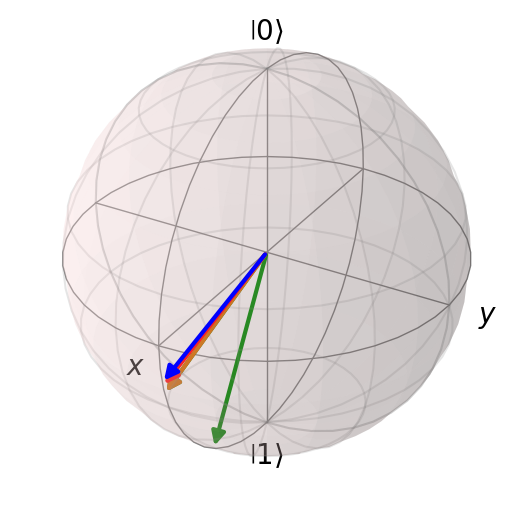

None

In [73]:
states = []
for i in range(len(bloch_data)):
    row = bloch_data.iloc[i]
    
    if(row.name.count('0') <= 1):
        alfa,beta = row['alfa'], row['beta']
        states.append(Qobj([[alfa], [beta]]))
show_bloch(states)

---

In [11]:
def show_unitary(qc, sim=AerSimulator()):
    qc_c = qc.copy()
    qc_c.save_unitary()
    transpiled = transpile(qc_c, sim)
    u = sim.run(transpiled, shots=1000).result().get_unitary()
    display(array_to_latex(u, max_size=100000))

In [68]:
d = pd.DataFrame(columns=("a", "b", "c"))
d["a"] = 

,a,b,c


In [12]:
BIT_STRINGS_2 = ['00', '01', '10', '11']

def test_angle_with_multiple_bit_strings(bit_strings):
    df = pd.DataFrame(columns=("angle", *bit_strings, "default"), index=bit_strings)
    
    for string in bit_strings:
        oracle = phase_oracle([string])
        n_grover,theta = new_grover(oracle.copy()) 
        best_angle, best_total = find_best_angle(theta, n_grover, np.linspace(0, pi, num=1000), string, debug=False)
        df.loc[string]['angle'] = best_angle
        df.loc[string][string] = best_total

        default = classical_grover(oracle.copy())
        default_counts = get_counts(default)
  
        default_total = 0
        if(default_counts.get(string)):
            default_total = default_counts[string]
        df.loc[string]['default'] = default_total
    
        for string2 in set(bit_strings)-{string}:
            oracle = phase_oracle([string2])
            n_grover_2,theta_2 = new_grover(oracle.copy())
            bc = n_grover_2.assign_parameters({theta_2: best_angle})
            counts = get_counts(bc)
    
            total = 0
            if(counts.get(string2)):
                total = counts[string2]

            df.loc[string2][string] = total
    
    return df

df = test_angle_with_multiple_bit_strings(BIT_STRINGS_2)
df

,angle,00,01,10,11,default
00,1.525198,1000,999,997,999,1000
01,1.515763,1000,1000,1000,1000,1000
10,1.503184,996,997,1000,1000,1000
11,1.522053,999,999,996,1000,1000


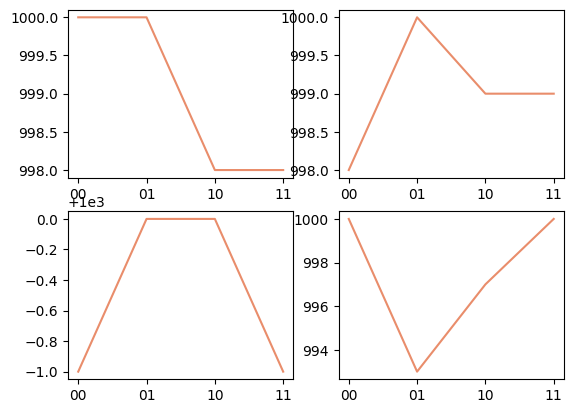

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(BIT_STRINGS_2, df['00'])
ax2.plot(BIT_STRINGS_2, df['01'])
ax3.plot(BIT_STRINGS_2, df['10'])
ax4.plot(BIT_STRINGS_2, df['11'])
plt.show()

In [76]:
df = test_angle_with_multiple_bit_strings(BIT_STRINGS_3)
df

,angle,000,001,010,011,100,101,110,111,default
000,1.000026,946,818,864,670,829,723,758,505,766
001,1.462303,663,828,806,710,788,762,756,587,777
010,1.383684,662,771,817,714,793,762,760,613,780
011,1.801935,538,766,732,814,721,774,794,706,787
100,1.456013,668,768,793,723,821,738,751,583,805
101,1.710737,542,751,727,779,747,817,805,714,769
110,1.644698,544,748,758,774,761,763,821,677,804
111,2.050369,476,713,708,876,725,849,821,942,801


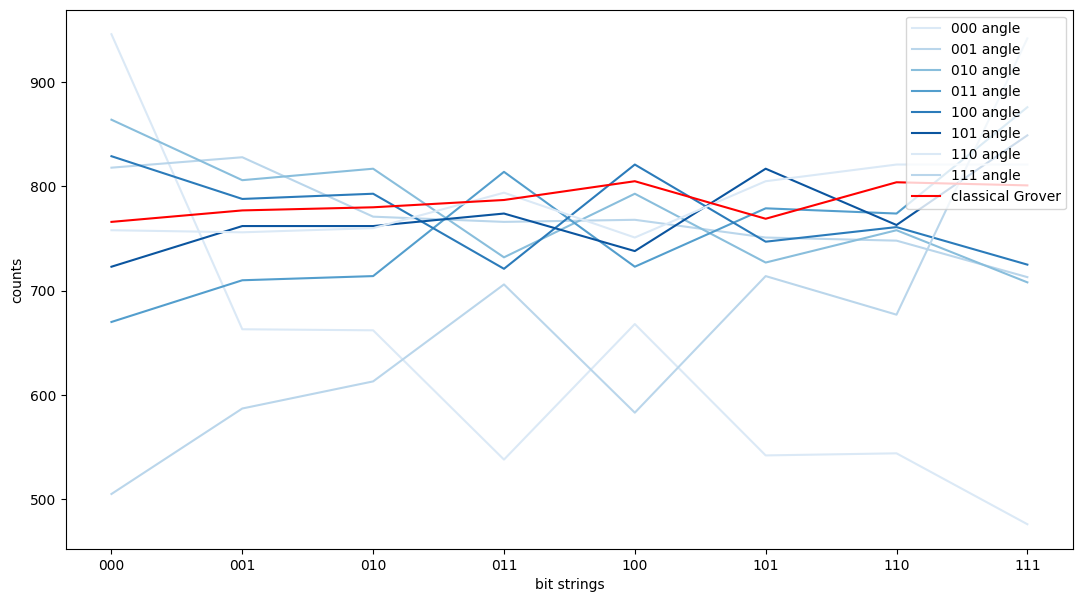

In [87]:
plt.figure(figsize=(13, 7))

sns.set_palette("Blues")
for string in BIT_STRINGS_3:
    sns.lineplot(data=df, x=BIT_STRINGS_3, y=string, label=f"{string} angle")

sns.lineplot(data=df, x=BIT_STRINGS_3, y="default", label="classical Grover", color="red")

plt.xlabel("bit strings")
plt.ylabel("counts")
plt.legend(loc="upper right")
plt.show()

In [88]:
df.describe()

,angle,000,001,010,011,100,101,110,111,default
count,8.000000,8,8,8,8,8,8,8,8,8
unique,8.000000,8,8,8,8,8,7,7,8,8
top,1.000026,946,818,864,670,829,762,821,505,766
freq,1.000000,1,1,1,1,1,2,2,1,1


In [89]:
df.std()

angle        0.314823
000        146.742182
001         37.381957
010         53.315603
011         66.508861
100         41.218711
101         41.019159
110         30.235977
111        132.050247
default      15.66103
dtype: object

In [117]:
angles = df['angle'][1:-2]
angles = angles.reset_index()
angles = angles.drop(columns=['index'])
angles.loc[5] = pi/2
angles

,angle
0,1.462303
1,1.383684
2,1.801935
3,1.456013
4,1.710737
5,1.570796


In [118]:
angles.std()

angle    0.162916
dtype: object

In [123]:
data = pd.DataFrame(columns=("+", "=", "-"), index=BIT_STRINGS_3)
default_theta = pi/2
deviation = angles.std()['angle']

In [126]:
for index, t_value in (('-', default_theta-deviation), ('=', default_theta), ('+', default_theta+deviation)): 
    for bit_string in BIT_STRINGS_3:
        oracle = phase_oracle([bit_string])
        ng, theta = new_grover(oracle)
        bc = ng.assign_parameters({theta:t_value})
        counts = get_counts(bc)
    
        total = 0
        if(counts.get(bit_string)):
            total = counts[bit_string]
    
        data.loc[bit_string][index] = total

In [127]:
data

,+,=,-
000,704,792,855
001,750,803,771
010,741,771,774
011,790,798,752
100,731,773,799
101,792,774,743
110,813,788,756
111,871,784,713


In [128]:
data.describe()

,+,=,-
count,8,8,8
unique,8,8,8
top,704,792,855
freq,1,1,1


In [129]:
data.std()

+    53.350592
=    12.023043
-    42.392511
dtype: object

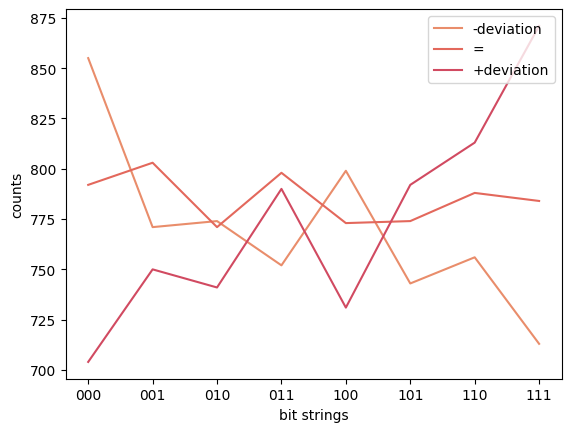

In [146]:
sns.set_palette("flare")
sns.lineplot(data=data, x=BIT_STRINGS_3, y='-', label="-deviation")
sns.lineplot(data=data, x=BIT_STRINGS_3, y='=', label="=")
sns.lineplot(data=data, x=BIT_STRINGS_3, y='+', label="+deviation")

plt.xlabel("bit strings")
plt.ylabel("counts")
plt.legend(loc="upper right")
plt.show()

---

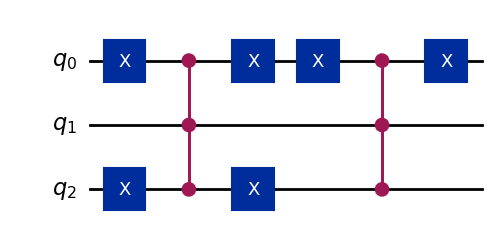

In [13]:
oracle = phase_oracle(['010', '110'])
oracle.draw('mpl')

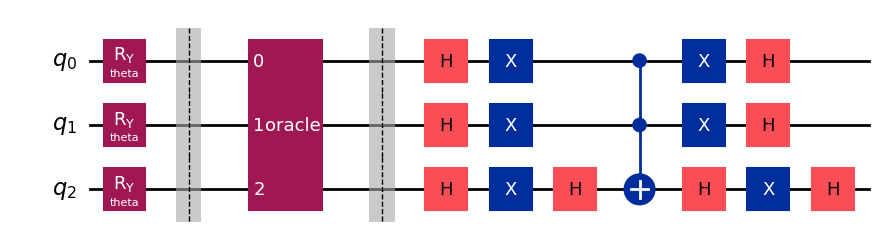

In [15]:
ng, theta = new_grover(oracle)
ng.draw('mpl')

In [13]:
def find_best_angle_multiple_bs(theta, qc, values_space, target_bit_strings, debug=False):
    best_angle = 0
    best_total = 0
    
    for angle in values_space:
        bc = qc.assign_parameters({theta:angle})
        counts = get_counts(bc)

        value = 0
        for bit_string in target_bit_strings:
            if(counts.get(bit_string)):
                value += counts[bit_string]

        if(value > best_total):
            best_total = value
            best_angle = angle
        
        if(debug):
            print(angle, value)

    return best_angle, best_total

In [18]:
angle, max_ = find_best_angle_multiple_bs(theta, ng, np.linspace(0, pi, num=1000), ['010', '110'])
angle,max_

(1.5031844728888097, 1000)

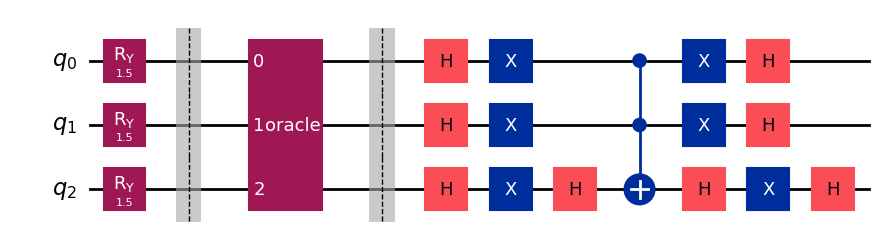

In [19]:
ng, theta = new_grover(oracle)
bc = ng.assign_parameters({theta:angle})
bc.draw('mpl')

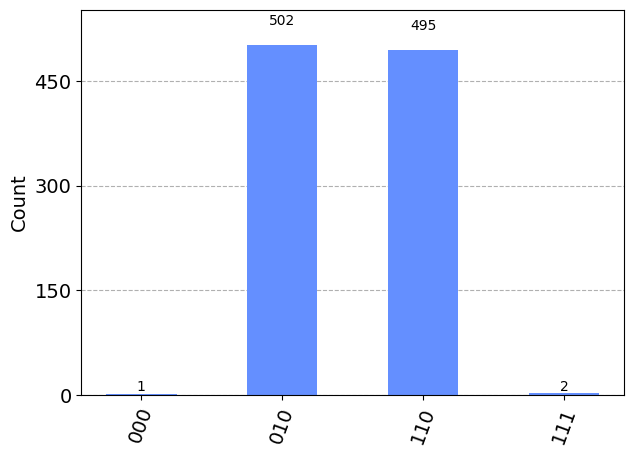

In [20]:
plot_histogram(get_counts(bc))

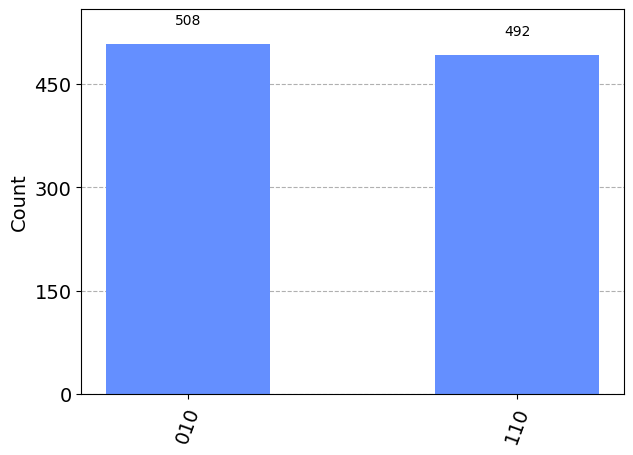

In [22]:
c = classical_grover(oracle)
plot_histogram(get_counts(c))

In [36]:
df = pd.DataFrame(columns=("bs_1", "bs_2", "bs_3", "angle","max_new", "max_old"))

for i, comb in enumerate(combinations(BIT_STRINGS_3, 3)):
    oracle = phase_oracle(comb)
    
    old_ = classical_grover(oracle.copy())
    new_,theta = new_grover(oracle.copy())


    #get old
    old_counts = get_counts(old_)
    total_old = 0
    for c in comb:
        if(old_counts.get(c)):
            total_old += old_counts[c]


    #get new
    angle, max_ = find_best_angle_multiple_bs(theta, new_, np.linspace(0, pi, num=200), comb)


    df.loc[i] = (comb[0], comb[1], comb[2], angle, max_, total_old)


In [37]:
df

,bs_1,bs_2,bs_3,angle,max_new,max_old
0,000,001,010,1.957575,949,832
1,000,001,011,1.862854,896,829
2,000,001,100,1.973362,940,857
3,000,001,101,1.768133,902,825
4,000,001,110,1.862854,901,848
5,000,001,111,1.673411,874,830
6,000,010,011,1.847067,904,831
7,000,010,100,1.910215,936,843
8,000,010,101,1.831280,897,850
9,000,010,110,1.736559,905,848


In [38]:
data = df
data["data"] = df["bs_1"] + " " + df["bs_2"] + " " + df["bs_3"]
data

,bs_1,bs_2,bs_3,angle,max_new,max_old,data
0,000,001,010,1.957575,949,832,000 001 010
1,000,001,011,1.862854,896,829,000 001 011
2,000,001,100,1.973362,940,857,000 001 100
3,000,001,101,1.768133,902,825,000 001 101
4,000,001,110,1.862854,901,848,000 001 110
5,000,001,111,1.673411,874,830,000 001 111
6,000,010,011,1.847067,904,831,000 010 011
7,000,010,100,1.910215,936,843,000 010 100
8,000,010,101,1.831280,897,850,000 010 101
9,000,010,110,1.736559,905,848,000 010 110


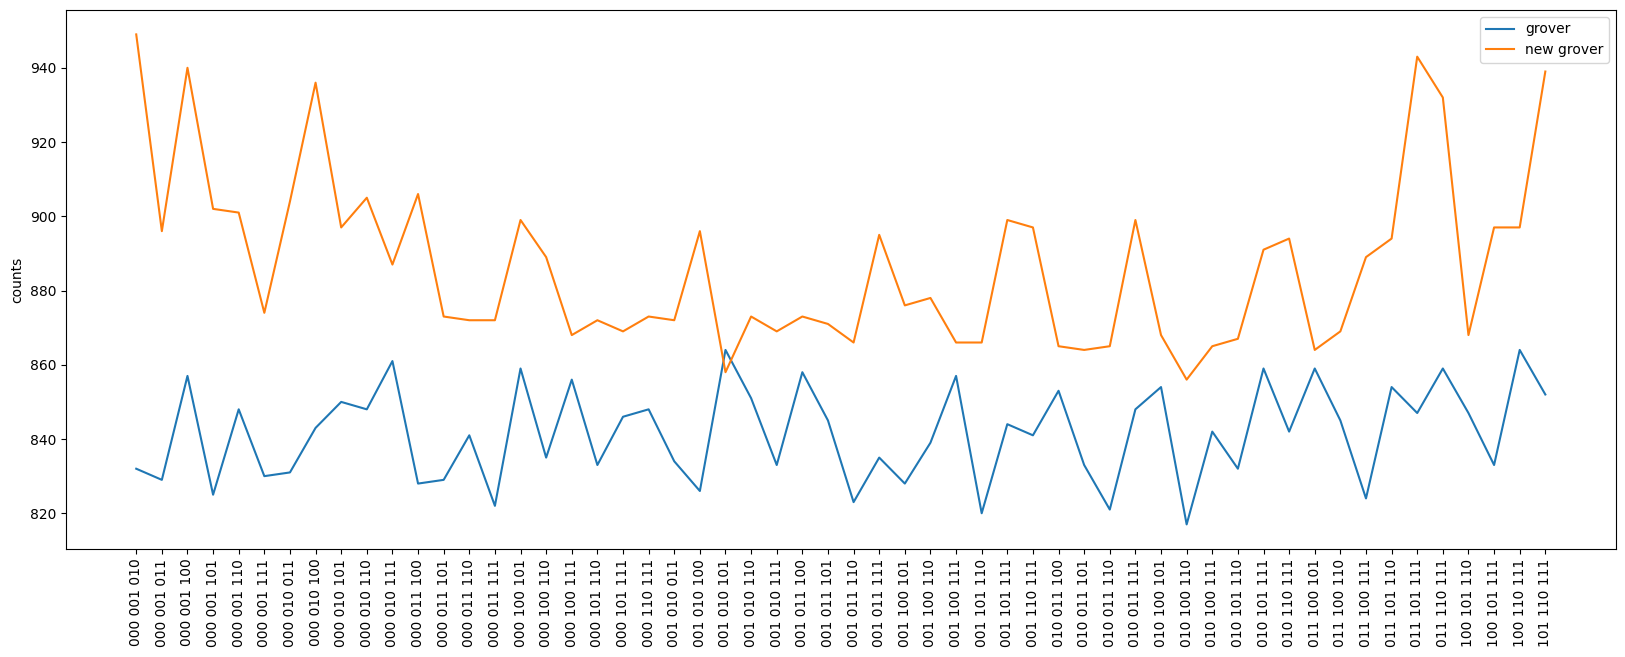

In [50]:
plt.figure(figsize=(20,7))
sns.lineplot(data=data, x="data", y="max_old", label="grover")
sns.lineplot(data=data, x="data", y="max_new", label="new grover")

plt.xlabel("")
plt.ylabel("counts")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.savefig(get_image_path("multiple_strings_new_grover_best_angles.png"))
plt.show()

In [48]:
data['alfa'] = np.cos(data["angle"]/2)
data['beta'] = np.sin(data["angle"]/2)
data

,bs_1,bs_2,bs_3,angle,max_new,max_old,data,alfa,beta
0,000,001,010,1.957575,949,832,000 001 010,0.558029,0.829821
1,000,001,011,1.862854,896,829,000 001 011,0.596689,0.802472
2,000,001,100,1.973362,940,857,000 001 100,0.551462,0.834200
3,000,001,101,1.768133,902,825,000 001 101,0.634012,0.773323
4,000,001,110,1.862854,901,848,000 001 110,0.596689,0.802472
5,000,001,111,1.673411,874,830,000 001 111,0.669912,0.742440
6,000,010,011,1.847067,904,831,000 010 011,0.603005,0.797737
7,000,010,100,1.910215,936,843,000 010 100,0.577521,0.816376
8,000,010,101,1.831280,897,850,000 010 101,0.609283,0.792953
9,000,010,110,1.736559,905,848,000 010 110,0.646141,0.763218


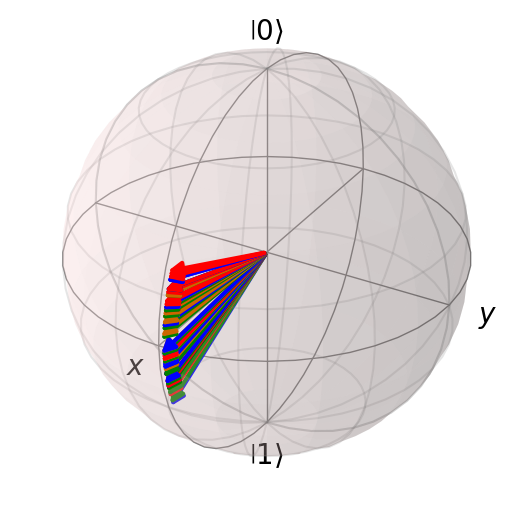

None

In [49]:
states = []
for i in range(len(data)):
    row = data.loc[i]
    alfa,beta = row['alfa'], row['beta']
    states.append(Qobj([[alfa], [beta]]))
show_bloch(states)

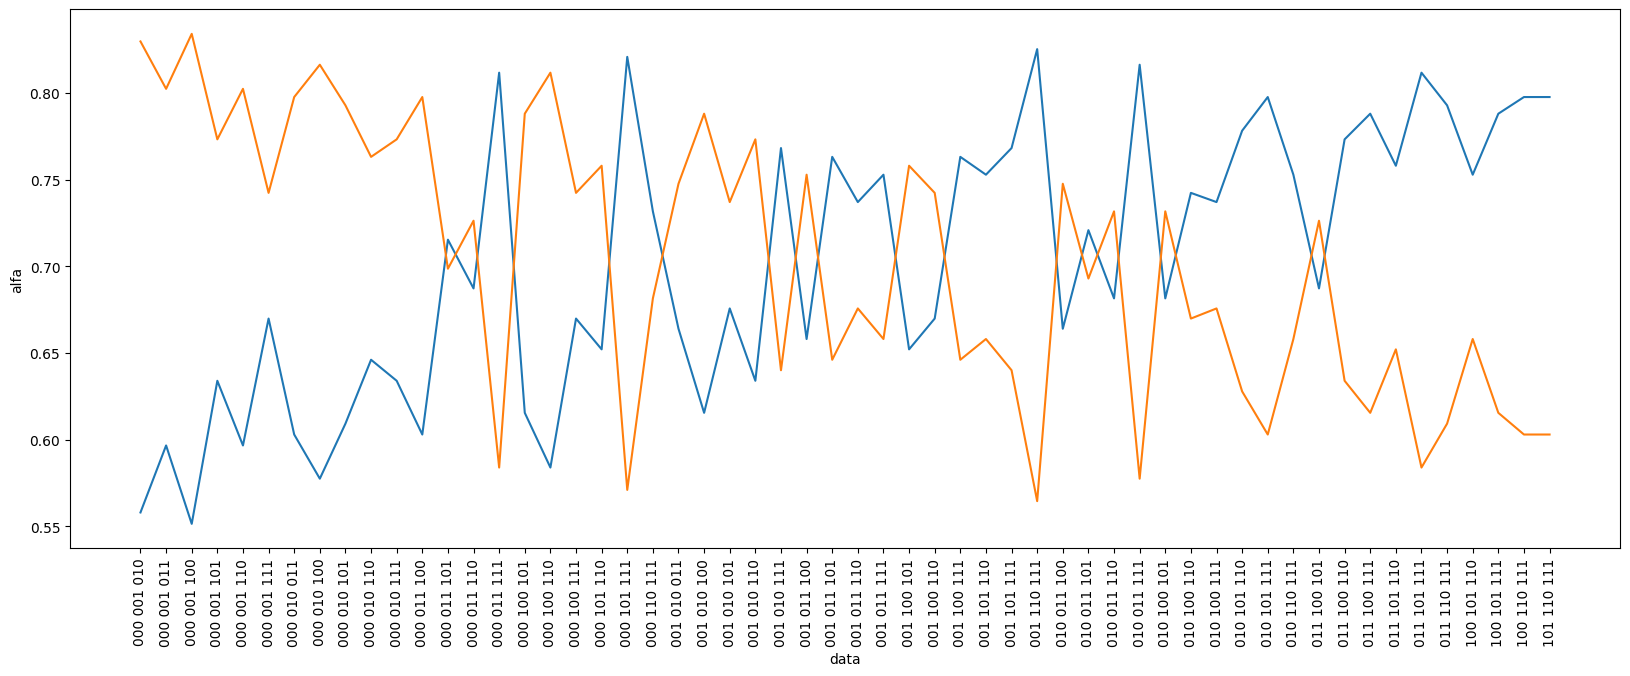

In [55]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=data, x="data", y="alfa")
sns.lineplot(data=data, x="data", y="beta")
plt.xticks(rotation=90)
plt.show()

In [59]:
data["t_zeros"] = data["data"].str.count('0')
data

,bs_1,bs_2,bs_3,angle,max_new,max_old,data,alfa,beta,t_zeros
0,000,001,010,1.957575,949,832,000 001 010,0.558029,0.829821,7
1,000,001,011,1.862854,896,829,000 001 011,0.596689,0.802472,6
2,000,001,100,1.973362,940,857,000 001 100,0.551462,0.834200,7
3,000,001,101,1.768133,902,825,000 001 101,0.634012,0.773323,6
4,000,001,110,1.862854,901,848,000 001 110,0.596689,0.802472,6
5,000,001,111,1.673411,874,830,000 001 111,0.669912,0.742440,5
6,000,010,011,1.847067,904,831,000 010 011,0.603005,0.797737,6
7,000,010,100,1.910215,936,843,000 010 100,0.577521,0.816376,7
8,000,010,101,1.831280,897,850,000 010 101,0.609283,0.792953,6
9,000,010,110,1.736559,905,848,000 010 110,0.646141,0.763218,6


In [67]:
more_zeros = data[data['t_zeros'] >= 5]
more_zeros

,bs_1,bs_2,bs_3,angle,max_new,max_old,data,alfa,beta,t_zeros
0,000,001,010,1.957575,949,832,000 001 010,0.558029,0.829821,7
1,000,001,011,1.862854,896,829,000 001 011,0.596689,0.802472,6
2,000,001,100,1.973362,940,857,000 001 100,0.551462,0.834200,7
3,000,001,101,1.768133,902,825,000 001 101,0.634012,0.773323,6
4,000,001,110,1.862854,901,848,000 001 110,0.596689,0.802472,6
5,000,001,111,1.673411,874,830,000 001 111,0.669912,0.742440,5
6,000,010,011,1.847067,904,831,000 010 011,0.603005,0.797737,6
7,000,010,100,1.910215,936,843,000 010 100,0.577521,0.816376,7
8,000,010,101,1.831280,897,850,000 010 101,0.609283,0.792953,6
9,000,010,110,1.736559,905,848,000 010 110,0.646141,0.763218,6


In [69]:
more_zeros[['alfa', 'beta', 't_zeros']].describe()

,alfa,beta,t_zeros
count,28.000000,28.000000,28.000000
mean,0.637912,0.767882,5.571429
std,0.045601,0.038383,0.690066
min,0.551462,0.669912,5.000000
25%,0.603005,0.742440,5.000000
50%,0.640076,0.768271,5.000000
75%,0.669912,0.797737,6.000000
max,0.742440,0.834200,7.000000


In [77]:
more_zeros['alfa'].mean()

0.6379116558672537

In [80]:
#alfa = cos(theta/2)
#cos^-1(alfa) = theta/2
#(cos^-1(alfa))*2 = theta

theta = np.arccos(more_zeros['alfa'].mean())*2
theta, np.degrees(theta)

(1.7580257328558584, 100.72745476803422)

In [85]:
melted = pd.melt(more_zeros, id_vars=['t_zeros'], value_vars=['alfa', 'beta'], var_name="amplitude")
melted

,t_zeros,amplitude,value
0,7,alfa,0.558029
1,6,alfa,0.596689
2,7,alfa,0.551462
3,6,alfa,0.634012
4,6,alfa,0.596689
5,5,alfa,0.669912
6,6,alfa,0.603005
7,7,alfa,0.577521
8,6,alfa,0.609283
9,6,alfa,0.646141


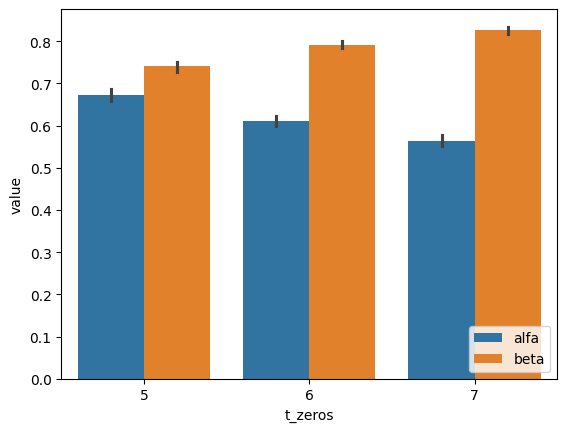

In [88]:
sns.barplot(data=melted, x="t_zeros", y="value", hue="amplitude")
plt.legend(loc="lower right")
plt.show()

In [90]:
data_2 = data
data_2 = data_2[['t_zeros', 'alfa', 'beta']]
data_2

,t_zeros,alfa,beta
0,7,0.558029,0.829821
1,6,0.596689,0.802472
2,7,0.551462,0.834200
3,6,0.634012,0.773323
4,6,0.596689,0.802472
5,5,0.669912,0.742440
6,6,0.603005,0.797737
7,7,0.577521,0.816376
8,6,0.609283,0.792953
9,6,0.646141,0.763218


In [91]:
melted_entire = pd.melt(data_2, id_vars=['t_zeros'], value_vars=['alfa', 'beta'], var_name="amplitude")
melted_entire

,t_zeros,amplitude,value
0,7,alfa,0.558029
1,6,alfa,0.596689
2,7,alfa,0.551462
3,6,alfa,0.634012
4,6,alfa,0.596689
...,...,...,...
107,2,beta,0.609283
108,4,beta,0.658109
109,3,beta,0.615523
110,3,beta,0.603005


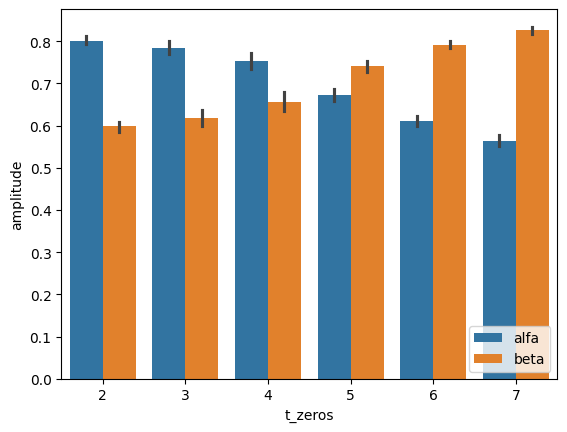

In [96]:
sns.barplot(data=melted_entire, x="t_zeros", y="value", hue="amplitude")
plt.legend(loc="lower right")
plt.ylabel("amplitude")
plt.savefig(get_image_path("amplitudes_based_on_total_zeros_new_grover.png"))
plt.show()

---

In [100]:
df = compare_old_new_1_bit_string(BIT_STRINGS_3, np.linspace(0, pi, num=200))
df

,old,new,angles
000,776,944,0.963001
001,793,819,1.515542
010,759,804,1.483968
011,775,820,1.704985
100,780,807,1.341886
101,789,801,1.657624
110,776,815,1.657624
111,773,938,2.099657


In [101]:
df['alfa'] = np.cos(df['angles']/2)
df['beta'] = np.sin(df['angles']/2)
df

,old,new,angles,alfa,beta
000,776,944,0.963001,0.886301,0.463109
001,793,819,1.515542,0.726370,0.687304
010,759,804,1.483968,0.737129,0.675752
011,775,820,1.704985,0.658109,0.752923
100,780,807,1.341886,0.783236,0.621725
101,789,801,1.657624,0.675752,0.737129
110,776,815,1.657624,0.675752,0.737129
111,773,938,2.099657,0.497720,0.867338


In [104]:
df['t_zeros'] = df.index.str.count('0')
df

,old,new,angles,alfa,beta,t_zeros
000,776,944,0.963001,0.886301,0.463109,3
001,793,819,1.515542,0.726370,0.687304,2
010,759,804,1.483968,0.737129,0.675752,2
011,775,820,1.704985,0.658109,0.752923,1
100,780,807,1.341886,0.783236,0.621725,2
101,789,801,1.657624,0.675752,0.737129,1
110,776,815,1.657624,0.675752,0.737129,1
111,773,938,2.099657,0.497720,0.867338,0


In [105]:
melted_entire_2 = pd.melt(df, id_vars=['t_zeros'], value_vars=['alfa', 'beta'], var_name="amplitude")
melted_entire_2

,t_zeros,amplitude,value
0,3,alfa,0.886301
1,2,alfa,0.726370
2,2,alfa,0.737129
3,1,alfa,0.658109
4,2,alfa,0.783236
5,1,alfa,0.675752
6,1,alfa,0.675752
7,0,alfa,0.497720
8,3,beta,0.463109
9,2,beta,0.687304


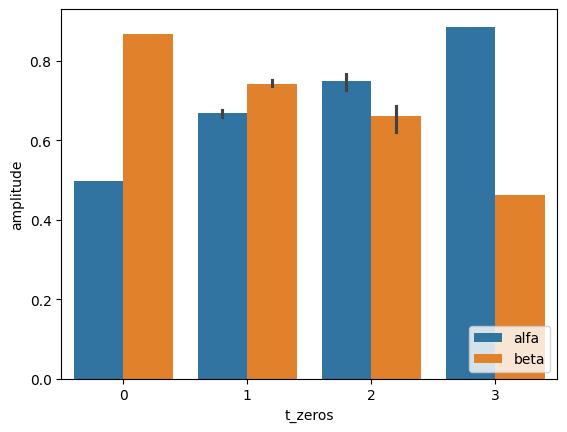

In [107]:
sns.barplot(data=melted_entire_2, x="t_zeros", y="value", hue="amplitude")
plt.legend(loc="lower right")
plt.ylabel("amplitude")
plt.savefig(get_image_path("amplitudes_based_on_total_zeros_new_grover_one_bit_string.png"))
plt.show()

---

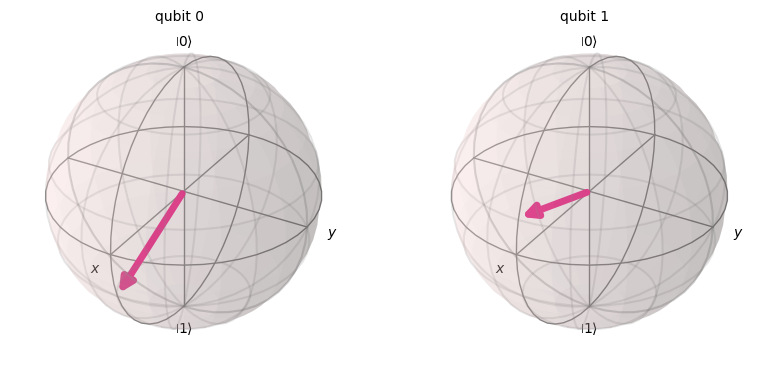

In [65]:
q = QuantumCircuit(2)
q.ry(1.957575,0)
q.ry(1.294526,1)
plot_bloch_multivector(q)

In [80]:
np.degrees((3*pi)/4)

135.0

In [123]:
def create_grover(strings):

    total_zeros = sum([ string.count('0') for string in strings ])
    n_qubits = len(strings[0])
    N = 2**n_qubits
    t = N/2
    
    if(n_qubits == 2):
        angle = pi/2

    if(total_zeros == n_qubits):
        angle = 0.963001
    elif(total_zeros == 0):
        angle = 2.099657
    else:
        angle = 1.657624
    
    
    
    oracle = phase_oracle(strings)
    ng, theta = new_grover(oracle)
    bc = ng.assign_parameters({theta:angle})
    return bc

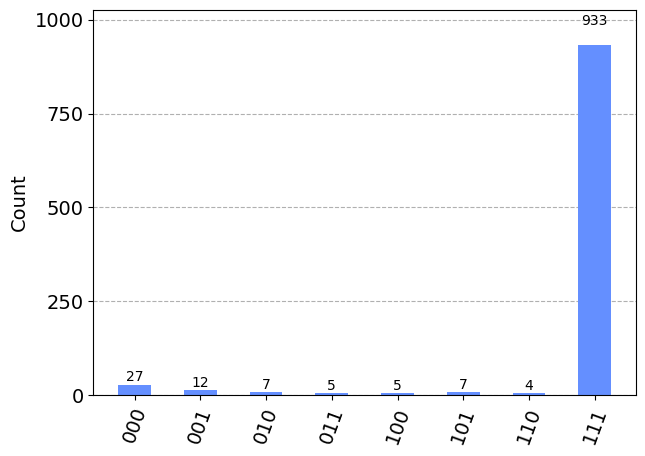

In [124]:
g = create_grover(['111'])
plot_histogram(get_counts(g))

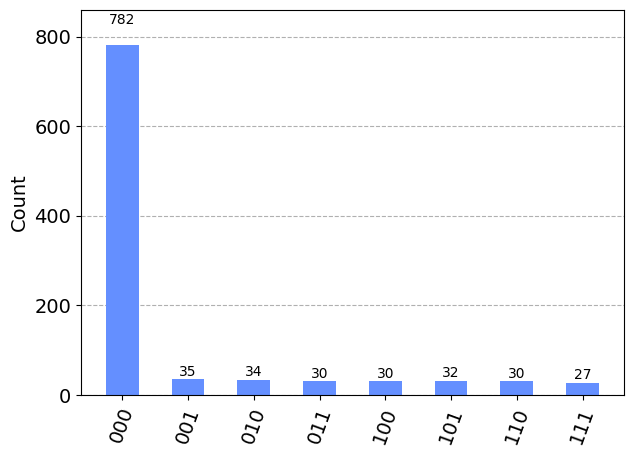

In [128]:
o = phase_oracle(['000'])
c = classical_grover(o)
plot_histogram(get_counts(c))

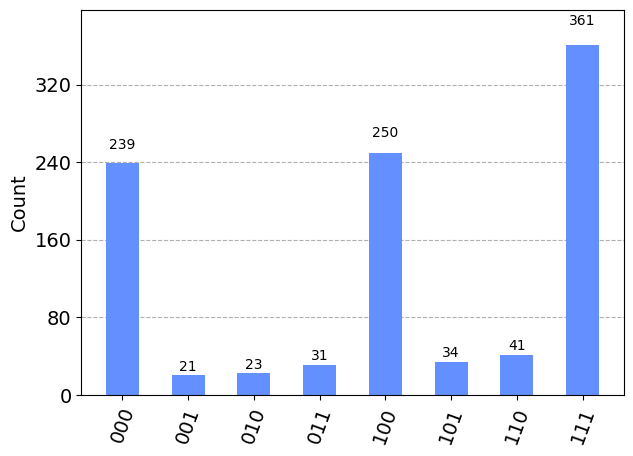

In [120]:
plot_histogram(get_counts(create_grover(['100','111', '000'])))

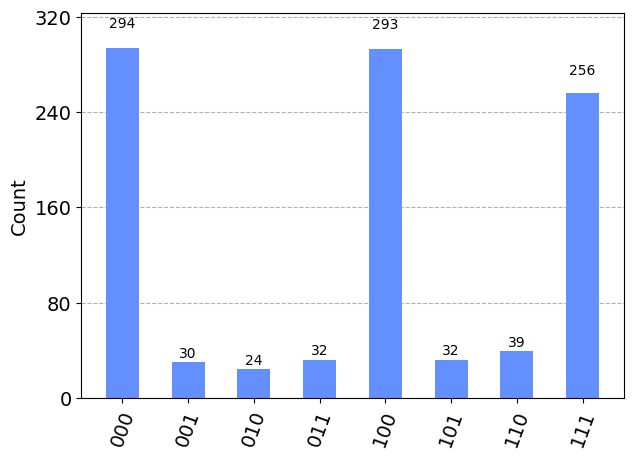

In [74]:
o = phase_oracle(['100','111', '000'])
c = classical_grover(o)
plot_histogram(get_counts(c))